In [231]:
# Import the required libraries
import os
# import packages for Part 2
import nltk 
import nltk, re, pprint
from wordcloud import WordCloud, ImageColorGenerator 
from PIL import Image 
import urllib.request
from stop_words import get_stop_words
from nltk.corpus import stopwords
from urllib import request
import pprint
from nltk import word_tokenize
from matplotlib.pyplot import text
import string
import csv
import networkx as nx
import operator
import numpy as np
import numpy.random
import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import powerlaw
import ast
import math
from bs4 import BeautifulSoup
from collections import Counter
from community import community_louvain
import itertools
# from fa2 import ForceAtlas2


In [232]:
# Load Graph
DC_Marvel_Graph = nx.read_gpickle("/Users/lx1023696171/Documents/0_DTU_study/02825 Social graphs and interactions/assignment2/Data/graph.gpickle")

# Load Wikipages as a dictionary with key the CharacterName and value the text of the wikipage
with open('/Users/lx1023696171/Documents/0_DTU_study/02825 Social graphs and interactions/assignment2/Data/wikipages.txt') as f:
    data = f.read()
    
wikipages_text = ast.literal_eval(data)
  

# Communities

Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

### functions

In [234]:

# path = r"/Users/lx1023696171/Downloads/SocialGraphsAndInteractions2022-main/Assignment2/Data/Marvel"

def get_wordsListForUniverse(path):
    os.chdir(path)
    # iterate through all file
    Text_all = []
    for file in os.listdir():
        # Check whether file is in text format or not
        if file.endswith(".txt"):
            file_path = f"{path}/{file}"
            f = open(file_path)
            # call read text file function
            text = f.read()

            # get text from html (output is a list)
            raw = BeautifulSoup(text, 'html.parser').get_text()
            tokens = word_tokenize(raw)

            # change the list to a string
            Str = ""
            for i in range(len(tokens)):
                Str = Str + ' ' + tokens[i]

                    # Remove all punctuation from your list of tokens
            text = Str.translate(str.maketrans('', '', string.punctuation))
            # Set everything to lowercase
            text = text.lower()
            # Divide the whole string into words
            tokens = word_tokenize(text)

            # Delete the stopwords in the text
            stop_words = list(get_stop_words('en'))         #Have around 900 stopwords
            nltk_words = list(stopwords.words('english'))   #Have around 150 stopwords
            stop_words.extend(nltk_words)
            tokens_ = []
            for words in tokens:
                if not words in stop_words:
                    tokens_.append(words)

            # Remove the words that too short or too long
            tokens_1 = []
            for i in range(len(tokens_)):
                if 2 < len(tokens_[i]) <15 :
                    tokens_1.append(tokens_[i])

            Text_all.append(tokens_1)

        strAll = []
        for i in range(len(Text_all)):
            strAll += Text_all[i]

    return strAll
    

def get_community_text(communityNameList,path):
    Vaules_Text = []
    for i in range(len(communityNameList)):
        try:
            file = communityNameList[i].replace(" ", "_*_")
            file = file  + '.txt'
            file_path = f"{path}/{file}"
            f = open(file_path)
            text = f.read()
        except:
            pass
        
        # get text from html (output is a list)
        raw = BeautifulSoup(text, 'html.parser').get_text()
        tokens = word_tokenize(raw)
        # change the list to a string
        Str = ""
        for i in range(len(tokens)):
            Str = Str + ' ' + tokens[i]

        # Remove all punctuation from your list of tokens
        text = Str.translate(str.maketrans('', '', string.punctuation))
        # Set everything to lowercase
        text = text.lower()
        # Divide the whole string into words
        tokens = word_tokenize(text)

        # Delete the stopwords in the text
        stop_words = list(get_stop_words('en'))         #Have around 900 stopwords
        nltk_words = list(stopwords.words('english'))   #Have around 150 stopwords
        stop_words.extend(nltk_words)
        tokens_ = []
        for words in tokens:
            if not words in stop_words:
                tokens_.append(words)

        # Remove the words that too short or too long
        tokens_1 = []
        for i in range(len(tokens_)):
            if 2 < len(tokens_[i]) <15 :
                tokens_1.append(tokens_[i])

        Vaules_Text.append(tokens_1)

    return Vaules_Text


def Create_CommunityDict_Name_word(NameList,Vaules_Text):

    test_keys = NameList
    test_values = Vaules_Text
    communityDict_Name_word = Create_dict(NameList, Vaules_Text)

    return communityDict_Name_word

def get_frequencyDict(tokens):
    fdist1 = nltk.FreqDist(tokens)
    # count the frequency of every words
    dict_frequency = dict(fdist1.most_common())
    # Get most common X with dict
    return dict_frequency

def computeTF_bylist(wordlist): 
    tfDict = {}
    bowCount = len(wordlist)
    wordDict = get_frequencyDict(wordlist)
    for word, count in wordDict.items():
        tfDict[word] = round((count/float(bowCount)),5)
    tfDict = dict(sorted(tfDict.items(), key=lambda item: item[1], reverse=True)) # sort
    return tfDict

# input: dict, output:dict
def computeTF(wordDict, tokens): 
    tfDict = {}
    bowCount = len(tokens)
    for word, count in wordDict.items():
        tfDict[word] = round((count/float(bowCount)),5)
    tfDict = dict(sorted(tfDict.items(), key=lambda item: item[1], reverse=True)) # sort
    return tfDict

# input: dict, output:dict
def computeIDF(communityDict_Name_word, Community_Allword_tf):
    
    word_count = []
    WordList_withRow = list(communityDict_Name_word.values())
    WordList = dict(Community_Allword_tf.items())

    # Take the largest 1000 words to reduce the calculation time
    Length = len(dict(Community_Allword_tf.items()))
    if Length > 200:
        WordList_less = dict(itertools.islice(WordList.items(), 200))
    else:
        WordList_less = WordList

    for word in WordList_less:
        
        for word in WordList_less:
            count = 0
            for j in range(len(WordList_withRow)):
                if word in WordList_withRow[j]:
                    count += 1
            word_count.append(count)

    DictWords_counts = Create_dict(WordList_less, word_count)
    idfDict = {}
    N = len(WordList_withRow)
    for word, val in DictWords_counts.items():
        idfDict[word] = math.log10(N / float(val))
   
    idfDict = dict(sorted(idfDict.items(), key=lambda item: item[1], reverse=True)) # sorted
    return idfDict


def get_Name_word_frequency(communityDict_Name_word,communityNameList):

    community_TF_list = []
    community_words_list  = []
    community_All_words = []    
    for i in range(len(communityDict_Name_word)):
        ttt = list(communityDict_Name_word.values())[i]
        fdist1 = nltk.FreqDist(ttt)
        word_frequency = fdist1.most_common()

        token = list(communityDict_Name_word.values())[i]
        
        word_tf = computeTF(dict(word_frequency), token)
        community_TF_list.append(list(word_tf.items()))

        community_words_list.append(list(communityDict_Name_word.values())[i])

    # Combine all words from lists in a community
    for j in range(len(community_words_list)):
        community_All_words += community_words_list[j]

    fdist2 = nltk.FreqDist(community_All_words)
    Allword_frequency = fdist2.most_common()

    # tokens_all is a list including all words of the community
    tokens_all = []
    L = list(communityDict_Name_word.values())
    for i in range(len(L)):
        tokens_all += L[i]
    Community_Allword_tf = computeTF(dict(Allword_frequency), tokens_all)

    Name_word_tf = {}
    test_keys = communityNameList
    test_values = community_TF_list
    for key in test_keys:
        for value in test_values:
            Name_word_tf [key] = value
            test_values.remove(value)
            break
    return Name_word_tf, Community_Allword_tf


def computeTFIDF(tfDict, idfDict):
    tf_idf = {}

    if len(tfDict) <= len(idfDict):
        for word, val in tfDict.items():
            tf_idf[word] = val * idfDict[word]

    elif len(tfDict) > len(idfDict):
        for word, val in idfDict.items():
            tf_idf[word] = val * tfDict[word]

    tf_idf = dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True))

    return tf_idf
    

def Create_dict(test_keys, test_values):
    Dict_ = {}
    for key in test_keys:
        for value in test_values:
            Dict_ [key] = value
            test_values.remove(value)
            break
    return Dict_ 


# discard disconnected nodes from the network
def check_nodes(G):
    d_out = dict(G.out_degree())
    key0_out = [k for k, v in d_out.items() if v == 0]
    # get the heros'name-list that out-degree is 0

    d_in = dict(G.in_degree())
    key0_in = [k for k, v in d_in.items() if v == 0]
    # get the heros'name-list that in-degree is 0

    nodesDegree_0 = []
    for i in key0_out:
        if i in key0_in:
            nodesDegree_0.append(i)
    G.remove_nodes_from(nodesDegree_0)
    return G



### Data

In [235]:
# Get Marvel networtx
DC_Marvel_Graph = nx.read_gpickle("/Users/lx1023696171/Documents/0_DTU_study/02825 Social graphs and interactions/assignment2/Data/graph.gpickle")
GM = DC_Marvel_Graph
MnodeList = list(GM.nodes(data=True))
# Delete = []
for nodeWithDate in MnodeList:
    if nodeWithDate[1]['universe'] == 'DC':
        GM.remove_node(nodeWithDate[0])

# Get DC networtx
DC_Marvel_Graph = nx.read_gpickle("/Users/lx1023696171/Documents/0_DTU_study/02825 Social graphs and interactions/assignment2/Data/graph.gpickle")
GD = DC_Marvel_Graph
DCnodeList = list(GD.nodes(data=True))
# Delete = []
for nodeWithDate in DCnodeList:
    if nodeWithDate[1]['universe'] == 'Marvel':
        GD.remove_node(nodeWithDate[0])

# # discard disconnected nodes from the network
GD = check_nodes(GD)
GM = check_nodes(GM)

In [240]:
pathM = r"/Users/lx1023696171/Downloads/SocialGraphsAndInteractions2022-main/Assignment2/Data/Marvel"
pathD = r"/Users/lx1023696171/Downloads/SocialGraphsAndInteractions2022-main/Assignment2/Data/DC"


wordsList_M = get_wordsListForUniverse(pathM)

wordsList_D = get_wordsListForUniverse(pathD)


# answers

### Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

In [ ]:
tfM = computeTF_bylist(wordsList_M)
tfM = list(tfM.items())[:15]
tfD = computeTF_bylist(wordsList_D)
tfD = list(tfD.items())[:15]

print(f'The 15 most frequently occurring words and their TFs in Marvel: \n {tfM}\n')
print(f'The 15 most frequently occurring words and their TFs in DC: \n {tfD}')

The 15 most frequently occurring words and their TFs in Marvel: 
 [('comics', 0.02183), ('marvel', 0.02046), ('cite', 0.00633), ('category', 0.00606), ('spiderman', 0.00603), ('avengers', 0.00547), ('character', 0.00509), ('new', 0.00481), ('xmen', 0.00453), ('vol', 0.00413), ('characters', 0.00397), ('man', 0.00376), ('comic', 0.00345), ('series', 0.00321), ('later', 0.00307)]

The 15 most frequently occurring words and their TFs in DC: 
 [('comics', 0.01797), ('batman', 0.00669), ('superman', 0.00657), ('category', 0.00615), ('cite', 0.00544), ('series', 0.00504), ('justice', 0.005), ('new', 0.00472), ('character', 0.00458), ('characters', 0.00434), ('league', 0.00434), ('vol', 0.00391), ('ref', 0.00348), ('comic', 0.00336), ('first', 0.00323)]


### Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

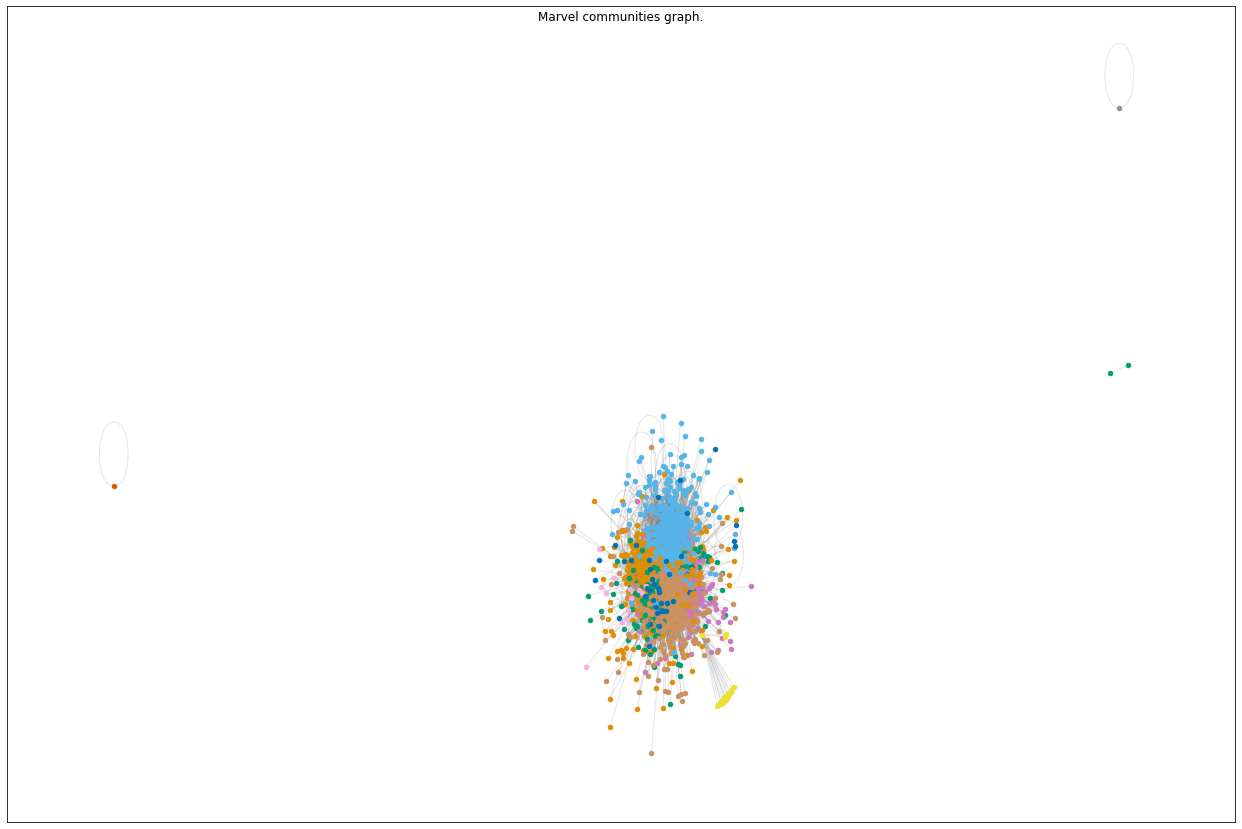

In [ ]:
# We chose the Marvel universe to continue our research below
from community import community_louvain
GM_un = nx.to_undirected(GM)
# plot network
fig, ax = plt.subplots(figsize=(22, 15))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=-1,

                        # Log
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(GM_un, pos=None, iterations=2000)


# create a random RMG-color list
import seaborn as sns
P = sns.color_palette("colorblind", 100).as_hex()

#first compute the best partition
partition = community_louvain.best_partition(GM_un)

#drawing
size = float(len(set(partition.values())))
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(GM_un, pos, list_nodes, node_size = 20, node_color=P[int(count)])


nx.draw_networkx_edges(GM_un, pos, alpha=0.2, edge_color = 'grey')

plt.title('Marvel communities graph.', pad=-14)

plt.show()

### Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.



Edit...

* The value of modularity for your network.

Edit...


* The number of communities and their sizes (in terms of number of nodes).

In [307]:
x = dict(Counter(partition.values()))
count = dict(sorted(x.items(), key=lambda item: item[1], reverse=True))
sorted_M = dict(sorted(x.items(), key=lambda item: item[1], reverse=True)[:10])
# Keys are the order number of the community
# values are the number of nodes
communityNumber = list(sorted_M.keys())
print(f"By best_partition of Louvain method, we get the number of communities of Marvel is {len(count)}")
print(f"The number of nodes in top 10 largest Marvel communities are {list(sorted_M.values())}")


By best_partition of Louvain method, we get the number of communities of Marvel is 12
The number of nodes in top 10 largest Marvel communities are [480, 391, 338, 185, 129, 41, 23, 17, 13, 2]


In [242]:
communityNameList1, communityNameList2, communityNameList3, communityNameList4, communityNameList5, communityNameList6, communityNameList7, communityNameList8, communityNameList9, communityNameList10,  = ([] for i in range(10))

# Create 10 community Name List including all the hero names of each community
for i in range(len(partition)):
    if list(partition.values())[i] == communityNumber[0]:
        communityNameList1.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[1]:
        communityNameList2.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[2]:
        communityNameList3.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[3]:
        communityNameList4.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[4]:
        communityNameList5.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[5]:
        communityNameList6.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[6]:
        communityNameList7.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[7]:
        communityNameList8.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[8]:
        communityNameList9.append(list(partition.keys())[i])
    elif list(partition.values())[i] == communityNumber[9]:
        communityNameList10.append(list(partition.keys())[i])

# Read the txt files for all Marvel wikipages
path = r"/Users/lx1023696171/Downloads/SocialGraphsAndInteractions2022-main/Assignment2/Data/Marvel"
Vaules_Text1,Vaules_Text2,Vaules_Text3,Vaules_Text4,Vaules_Text5,Vaules_Text6,Vaules_Text7,Vaules_Text8,Vaules_Text9,Vaules_Text10 = (
    get_community_text(communityNameList1,path),
    get_community_text(communityNameList2,path),
    get_community_text(communityNameList3,path),
    get_community_text(communityNameList4,path),
    get_community_text(communityNameList5,path),
    get_community_text(communityNameList6,path),
    get_community_text(communityNameList7,path),
    get_community_text(communityNameList8,path),
    get_community_text(communityNameList9,path),
    get_community_text(communityNameList10,path)
)


/Users/lx1023696171/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [243]:
# Get a Dictionary that keys are hero names of each community, values are important words in their wikipages.
communityDict_Name_word1,communityDict_Name_word2,communityDict_Name_word3,communityDict_Name_word4,communityDict_Name_word5,communityDict_Name_word6,communityDict_Name_word7,communityDict_Name_word8,communityDict_Name_word9,communityDict_Name_word10 = (
    Create_CommunityDict_Name_word(communityNameList1,Vaules_Text1),
    Create_CommunityDict_Name_word(communityNameList2,Vaules_Text2),
    Create_CommunityDict_Name_word(communityNameList3,Vaules_Text3),
    Create_CommunityDict_Name_word(communityNameList4,Vaules_Text4),
    Create_CommunityDict_Name_word(communityNameList5,Vaules_Text5),
    Create_CommunityDict_Name_word(communityNameList6,Vaules_Text6),
    Create_CommunityDict_Name_word(communityNameList7,Vaules_Text7),
    Create_CommunityDict_Name_word(communityNameList8,Vaules_Text8),
    Create_CommunityDict_Name_word(communityNameList9,Vaules_Text9),
    Create_CommunityDict_Name_word(communityNameList10,Vaules_Text10)
    )

# Dict_tf is tf of every hero'wikipage in communityX, Community_Allword_tf is a dict that keys are words in the Community and values are tf of each words
Dict_tf1, Community_Allword_tf1 = get_Name_word_frequency(communityDict_Name_word1,communityNameList1)
Dict_tf2, Community_Allword_tf2 = get_Name_word_frequency(communityDict_Name_word2,communityNameList2)
Dict_tf3, Community_Allword_tf3 = get_Name_word_frequency(communityDict_Name_word3,communityNameList3)
Dict_tf4, Community_Allword_tf4 = get_Name_word_frequency(communityDict_Name_word4,communityNameList4)
Dict_tf5, Community_Allword_tf5 = get_Name_word_frequency(communityDict_Name_word5,communityNameList5)
Dict_tf6, Community_Allword_tf6 = get_Name_word_frequency(communityDict_Name_word6,communityNameList6)
Dict_tf7, Community_Allword_tf7 = get_Name_word_frequency(communityDict_Name_word7,communityNameList7)
Dict_tf8, Community_Allword_tf8 = get_Name_word_frequency(communityDict_Name_word8,communityNameList8)
Dict_tf9, Community_Allword_tf9 = get_Name_word_frequency(communityDict_Name_word9,communityNameList9)
Dict_tf10, Community_Allword_tf10 = get_Name_word_frequency(communityDict_Name_word10,communityNameList10)

# idfDict1
idfDict1,idfDict2,idfDict3,idfDict4,idfDict5,idfDict6,idfDict7,idfDict8,idfDict9, idfDict10 = (
    computeIDF(communityDict_Name_word1, Community_Allword_tf1),
    computeIDF(communityDict_Name_word2, Community_Allword_tf2),
    computeIDF(communityDict_Name_word3, Community_Allword_tf3),
    computeIDF(communityDict_Name_word4, Community_Allword_tf4),
    computeIDF(communityDict_Name_word5, Community_Allword_tf5),
    computeIDF(communityDict_Name_word6, Community_Allword_tf6),
    computeIDF(communityDict_Name_word7, Community_Allword_tf7),
    computeIDF(communityDict_Name_word8, Community_Allword_tf8),
    computeIDF(communityDict_Name_word9, Community_Allword_tf9),
    computeIDF(communityDict_Name_word10, Community_Allword_tf10)
    )

tf_idf1, tf_idf2, tf_idf3, tf_idf4, tf_idf5, tf_idf6, tf_idf7, tf_idf8, tf_idf9, tf_idf10  =  (
    computeTFIDF(Community_Allword_tf1, idfDict1), 
    computeTFIDF(Community_Allword_tf2, idfDict2), 
    computeTFIDF(Community_Allword_tf3, idfDict3), 
    computeTFIDF(Community_Allword_tf4, idfDict4),
    computeTFIDF(Community_Allword_tf5, idfDict5),
    computeTFIDF(Community_Allword_tf6, idfDict6),
    computeTFIDF(Community_Allword_tf7, idfDict7),
    computeTFIDF(Community_Allword_tf8, idfDict8),
    computeTFIDF(Community_Allword_tf9, idfDict9),
    computeTFIDF(Community_Allword_tf10, idfDict10))

### Explain in your own words how TF-IDF works.

In [310]:

print(f"The largest 10 words with tf in community 1 is:\n{list(Community_Allword_tf1.keys())[:15]}\n")
idfDict1_reverse = dict(sorted(idfDict1.items(), key=lambda item: item[1], reverse=False))
print(f"The less 10 words with tf_idf in community 1 is:\n{list(idfDict1_reverse.keys())[:15]}\n")
print(f"The largest 10 words with tf_idf in community 1 is:\n{list(tf_idf1.keys())[:15]}")

The largest 10 words with tf in community 1 is:
['marvel', 'comics', 'cite', 'avengers', 'category', 'character', 'thor', 'hulk', 'vol', 'comic', 'new', 'universe', 'characters', 'four', 'fantastic']

The less 10 words with tf_idf in community 1 is:
['title', 'pages', 'main', 'revisions', 'pageid', 'slots', 'contentmodel', 'wikitext', 'contentformat', 'textxwiki', 'batchcomplete', 'query', 'comics', 'category', 'character']

The largest 10 words with tf_idf in community 1 is:
['thor', 'hulk', 'marvel', 'avengers', 'fantastic', 'ref', 'cite', 'loki', 'guardians', 'thanos', 'four', 'strange', 'galaxy', 'web', 'black']


According definition, the value of TF is proportional to how often a word appears. So TF can show the frequency of each word, without taking into account the specificity of words. The value of IDF is inversely proportional to how often the word appears in multiple documents...


### wordclouds

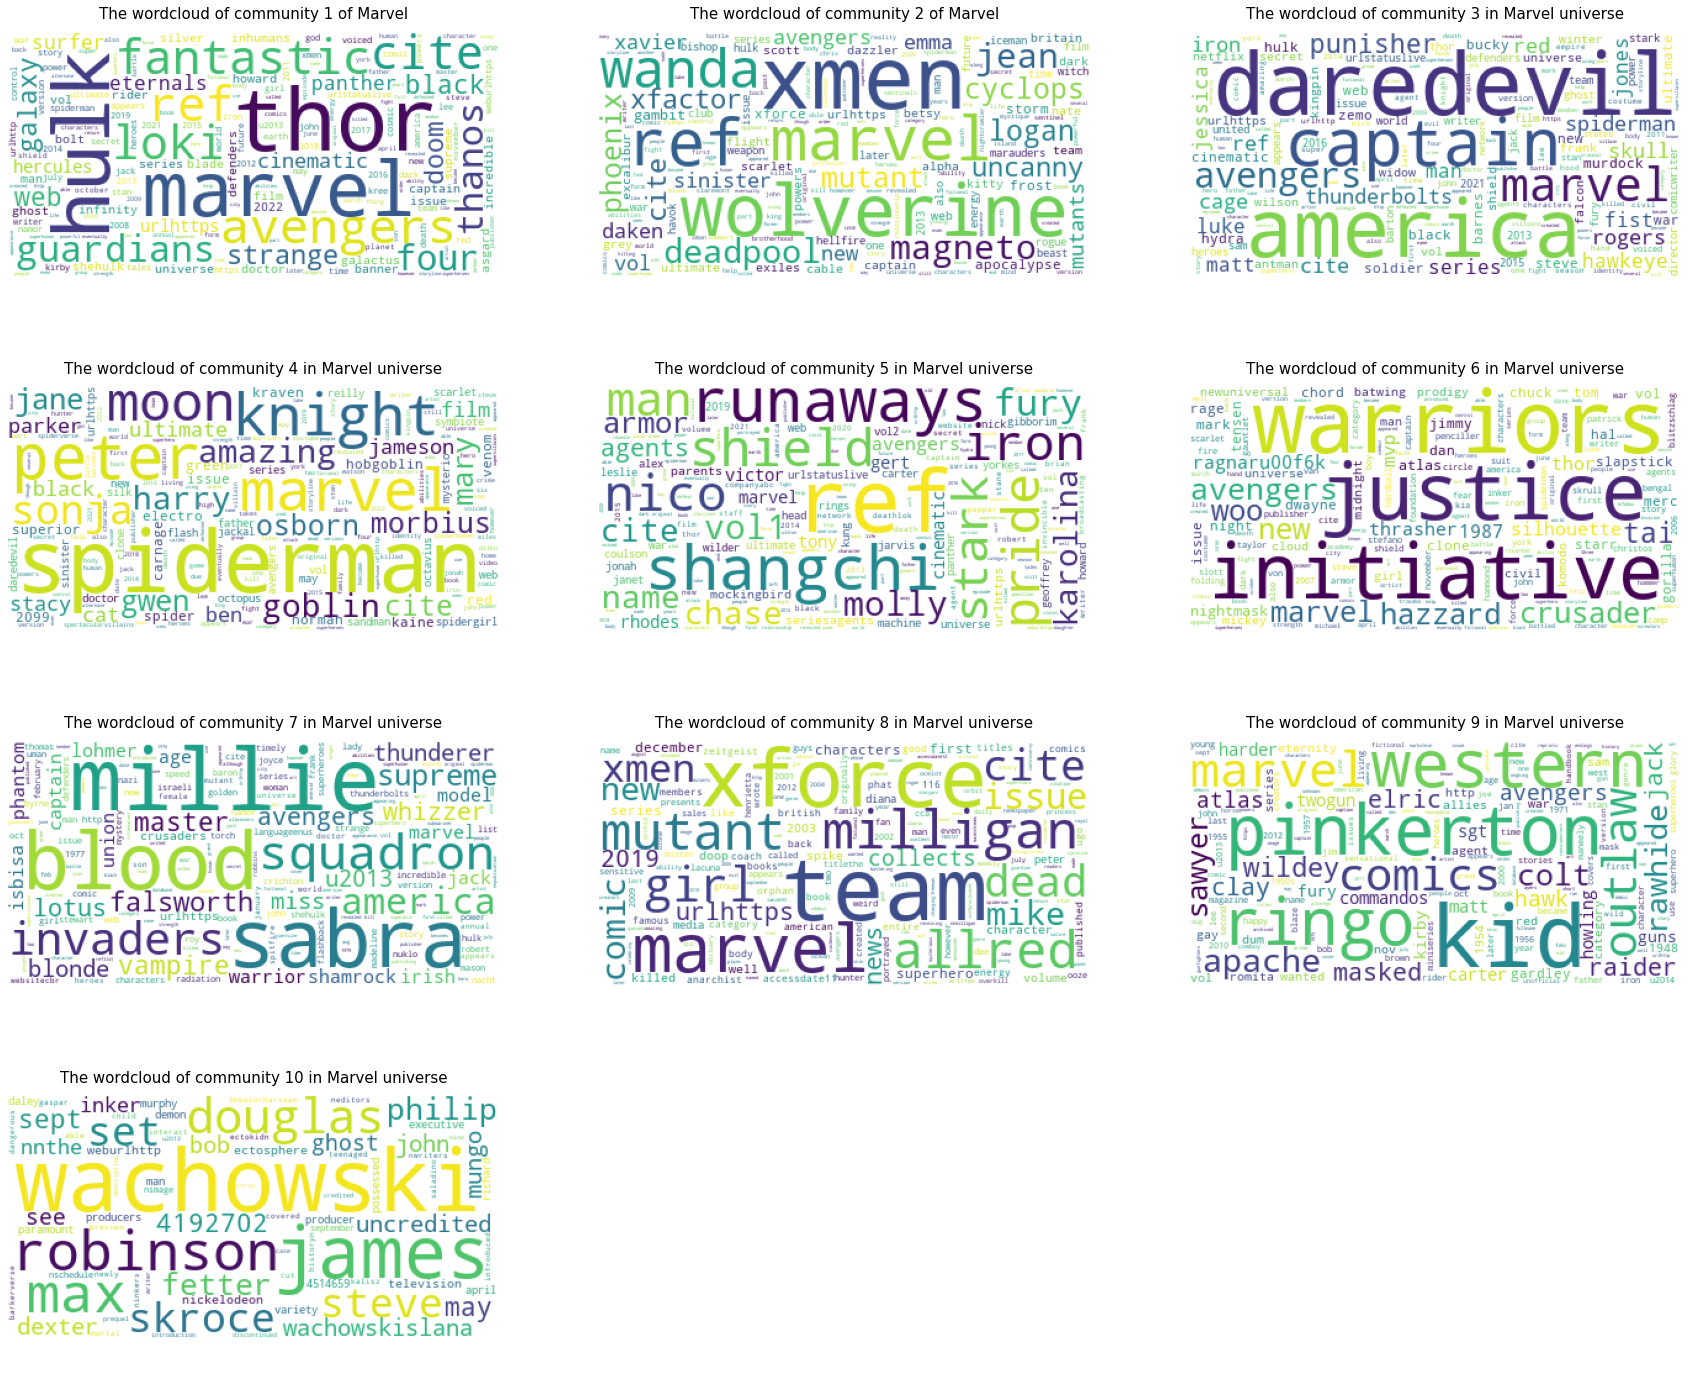

In [296]:
(wordcloud1,wordcloud2,wordcloud3,wordcloud4,wordcloud5,
wordcloud6,wordcloud7,wordcloud8,wordcloud9,wordcloud10) = ( WordCloud(background_color='white',max_font_size = 70) for i in range(10) )

wordcloud1.generate_from_frequencies(frequencies=tf_idf1)
wordcloud2.generate_from_frequencies(frequencies=tf_idf2)
wordcloud3.generate_from_frequencies(frequencies=tf_idf3)
wordcloud4.generate_from_frequencies(frequencies=tf_idf4)
wordcloud5.generate_from_frequencies(frequencies=tf_idf5)
wordcloud6.generate_from_frequencies(frequencies=tf_idf6)
wordcloud7.generate_from_frequencies(frequencies=tf_idf7)
wordcloud8.generate_from_frequencies(frequencies=tf_idf8)
wordcloud9.generate_from_frequencies(frequencies=tf_idf9)
wordcloud10.generate_from_frequencies(frequencies=tf_idf10)

fig, axs = plt.subplots(nrows=4, ncols = 3, figsize = (30, 25))

axs[0, 0].imshow(wordcloud1)
axs[0, 0].set_title('The wordcloud of community 1 of Marvel', fontsize = 15, pad=14)
axs[0, 0].axis("off")

axs[0, 1].imshow(wordcloud2)
axs[0, 1].set_title('The wordcloud of community 2 of Marvel',fontsize = 15, pad=14)
axs[0, 1].axis("off")

axs[0, 2].imshow(wordcloud3)
axs[0, 2].set_title('The wordcloud of community 3 in Marvel universe',fontsize = 15, pad=14)
axs[0, 2].axis("off")

axs[1, 0].imshow(wordcloud4)
axs[1, 0].set_title('The wordcloud of community 4 in Marvel universe',fontsize = 15, pad=14)
axs[1, 0].axis("off")

axs[1, 1].imshow(wordcloud5)
axs[1, 1].set_title('The wordcloud of community 5 in Marvel universe',fontsize = 15, pad=14)
axs[1, 1].axis("off")

axs[1, 2].imshow(wordcloud6)
axs[1, 2].set_title('The wordcloud of community 6 in Marvel universe',fontsize = 15, pad=14)
axs[1, 2].axis("off")

axs[2, 0].imshow(wordcloud7)
axs[2, 0].set_title('The wordcloud of community 7 in Marvel universe',fontsize = 15, pad=14)
axs[2, 0].axis("off")

axs[2, 1].imshow(wordcloud8)
axs[2, 1].set_title('The wordcloud of community 8 in Marvel universe',fontsize = 15, pad=14)
axs[2, 1].axis("off")

axs[2, 2].imshow(wordcloud9)
axs[2, 2].set_title('The wordcloud of community 9 in Marvel universe',fontsize = 15, pad=14)
axs[2, 2].axis("off")

axs[3, 0].imshow(wordcloud10)
axs[3, 0].set_title('The wordcloud of community 10 in Marvel universe',fontsize = 15, pad=14)
axs[3, 0].axis("off")

axs[3, 1].axis("off")
axs[3, 2].axis("off")

plt.show()
